In [1]:
import numpy as np
import struct
from array import array
from os.path  import join

class MnistDataloader(object):
    def __init__(
            self, 
            training_images_filepath,
            training_labels_filepath,
            test_images_filepath,
            test_labels_filepath
        ):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())

        images = [np.array(image_data[i * rows * cols:(i + 1) * rows * cols]).reshape(28, 28) for i in range(size)]
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)

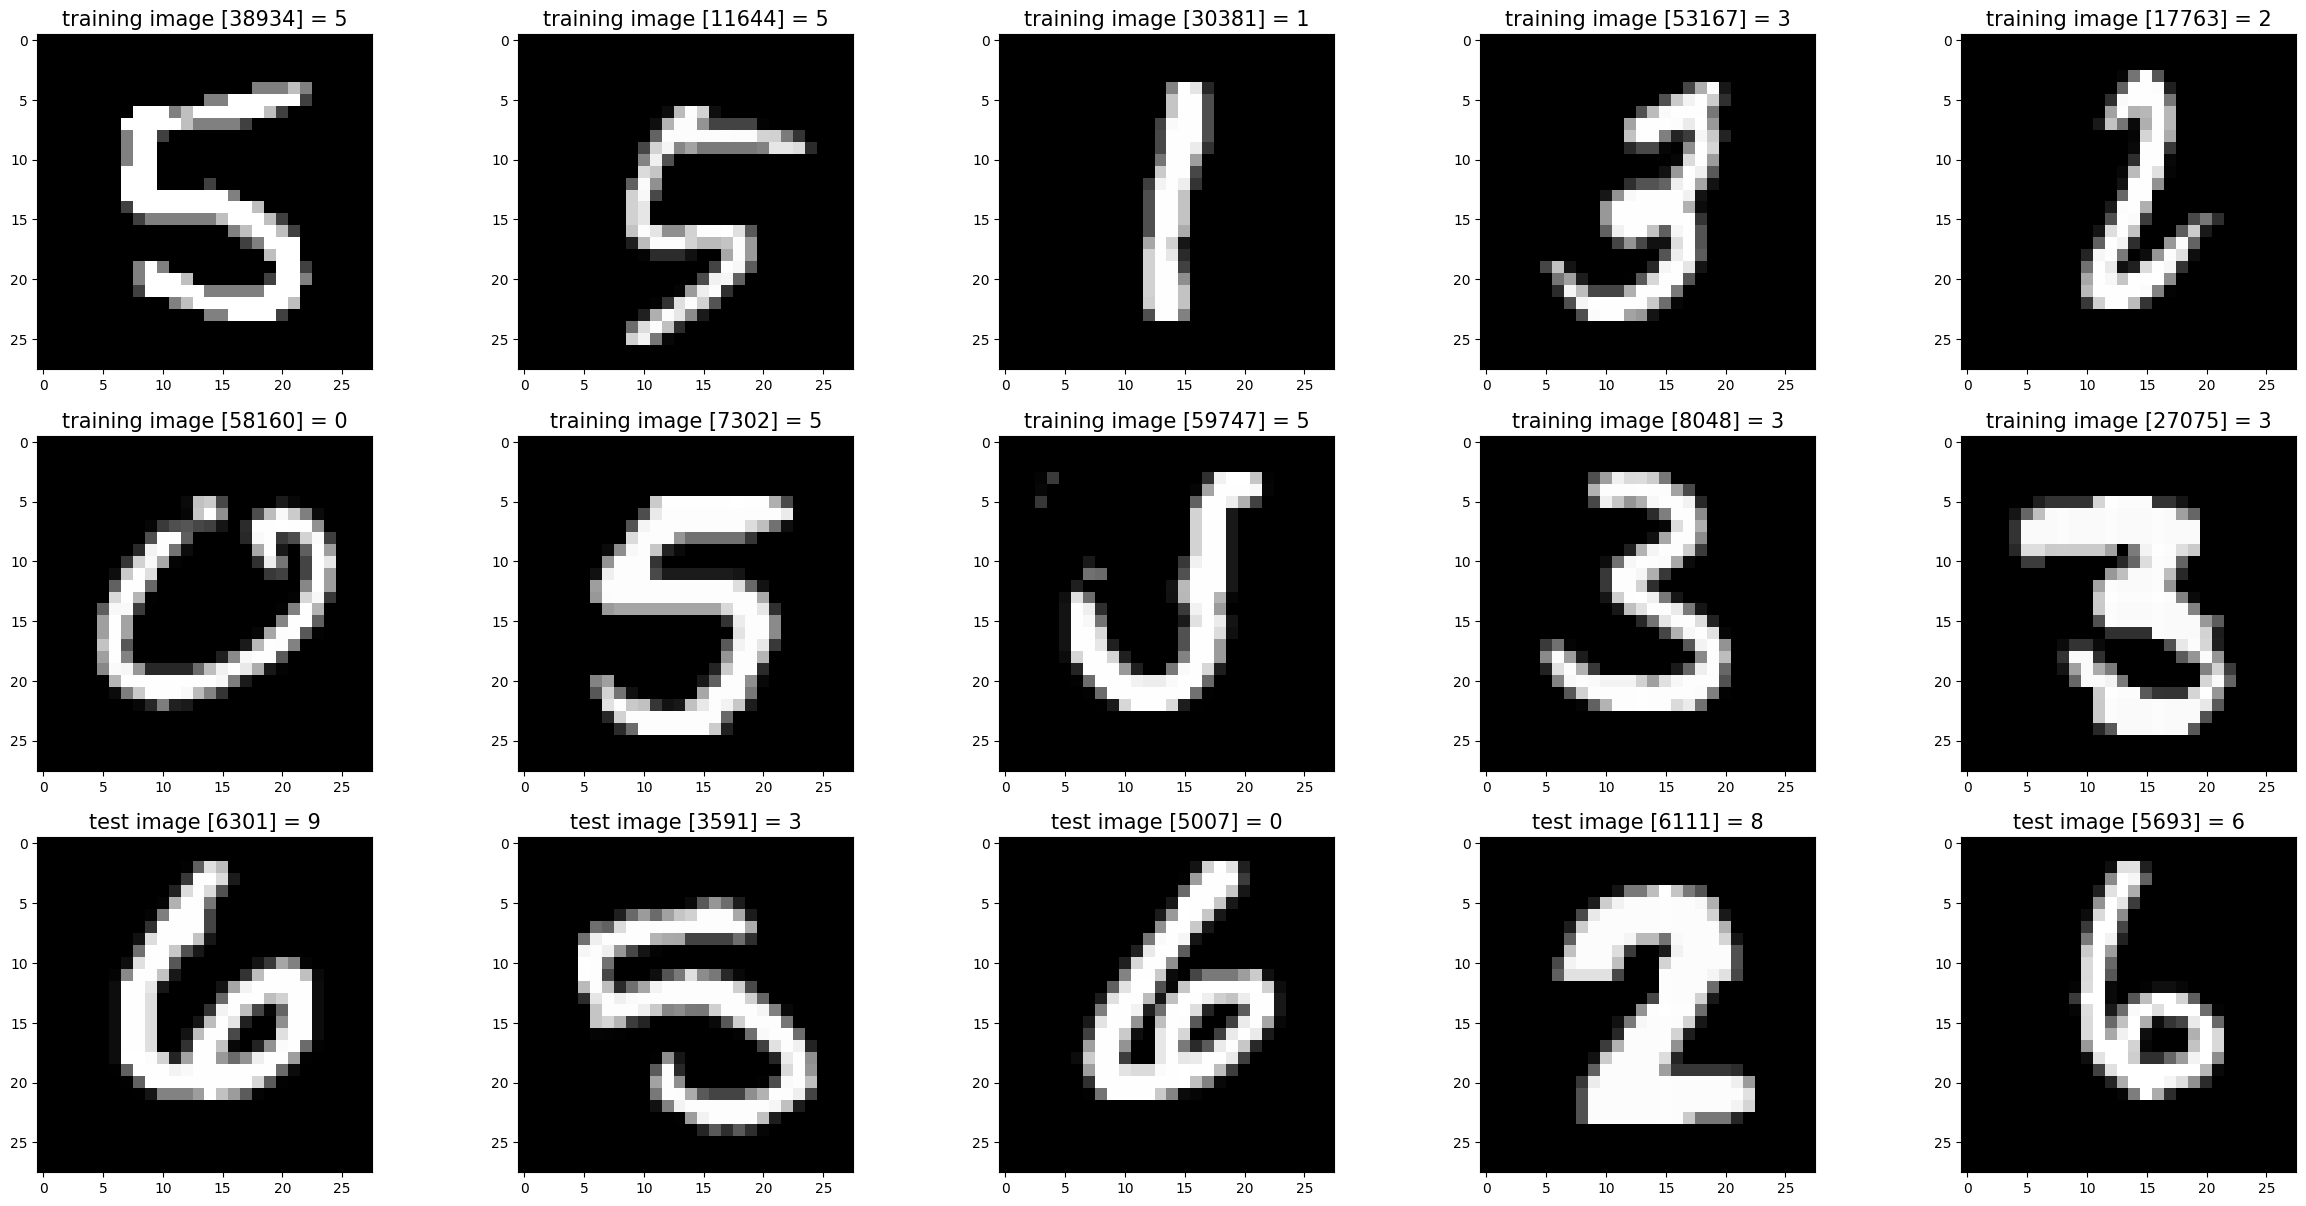

In [3]:
%matplotlib inline
import random
import matplotlib.pyplot as plt

input_path = 'data/'
training_images_filepath = join(input_path, 'train-images.idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels.idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images.idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels.idx1-ubyte')

def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for image, title_text in zip(images, title_texts):
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        plt.title(title_text, fontsize = 15)
        index += 1

mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

images_to_show = []
titles_to_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_to_show.append(x_train[r])
    titles_to_show.append(f"training image [{str(r)}] = {str(y_train[r])}")

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_to_show.append(x_test[r])
    titles_to_show.append(f"test image [{str(r)}] = {str(y_train[r])}")

show_images(images_to_show, titles_to_show)

In [10]:
print(x_train[r])

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  25 130 207 254 254 148
   65   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   3  86 234 253 246 187 213 253
  212  15   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0 195 253 253 119  38   

In [4]:
EPOCHS = 13
BATCH_SIZE = 32

In [5]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Load data
mnist_loader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_loader.load_data()

# Format the image data into a tensor with size (channels, cols, rows)
x_train, x_test = map(torch.FloatTensor, (x_train, x_test))
x_train, x_test = x_train.unsqueeze(1) / 255, x_test.unsqueeze(1) / 255

# Format the label data
y_train, y_test = map(torch.LongTensor, (y_train, y_test))

# Create datasets and dataloaders
train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)


/var/folders/_s/t3dfy9cn3hs2p7ym88jg00jw0000gn/T/ipykernel_92685/1321329539.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:248.)
  x_train, x_test = map(torch.FloatTensor, (x_train, x_test))


In [6]:
from collections import defaultdict

# Define the model
# model = torch.nn.Sequential(
#     torch.nn.Conv2d(1, 32, 3),
#     torch.nn.MaxPool2d(2, 2),
#     torch.nn.Conv2d(32, 64, 3),
#     torch.nn.MaxPool2d(2, 2),
#     torch.nn.Flatten(),
#     torch.nn.Linear(64 * 5 * 5, 64),
#     torch.nn.ReLU(),
#     torch.nn.Linear(64, 10),
#     torch.nn.Softmax(dim=1)
# )


model = torch.nn.Sequential(
    torch.nn.Conv2d(1, 8, 5),
    torch.nn.MaxPool2d(2, 2),
    torch.nn.Conv2d(8, 16, 3),
    torch.nn.MaxPool2d(2, 2),
    torch.nn.Flatten(),
    torch.nn.Linear(16 * 5 * 5, 32),
    torch.nn.ReLU(),
    torch.nn.Linear(32, 10),
    torch.nn.Softmax(dim=1)
)

# Loss and optimizer
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

# Dict for accumulating performance stats
stats = {}

# Training loop
for epoch in range(EPOCHS):

    model.train()

    stats[epoch + 1] = {}
    train_loss = 0
    train_accuracy = 0
    batch_train_loss = []
    batch_train_accuracy = []
    by_class = defaultdict(lambda: defaultdict(list))


    for batch_idx, (data, target) in enumerate(train_loader):
        # Forward pass
        output = model(data)
        loss = loss_function(output, target)

        # Accumulate training performance stats
        # Batch-level stats
        batch_train_loss.append(loss.item())
        correct_train = (output.argmax(1) == target).float().sum().item()
        batch_accuracy = correct_train / len(target)
        batch_train_accuracy.append(batch_accuracy)
        # Epoch-level stats
        train_loss += loss.item()
        train_accuracy += batch_accuracy
        # Per-class stats
        predictions = output.argmax(1)
        for class_idx in range(10): # Assuming 10 classes
            mask = target == class_idx
            class_loss = loss_function(output[mask], target[mask])
            correct_class = (predictions[mask] == target[mask]).float().sum().item()
            if mask.sum().item() == 0:
                class_accuracy = 0
            else:
                class_accuracy = correct_class / mask.sum().item()
            by_class[class_idx]["loss"].append(class_loss.item())
            by_class[class_idx]["accuracy"].append(class_accuracy)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_loss /= len(train_loader)
    train_accuracy /= len(train_loader)

    # Test for each epoch
    model.eval()
    test_loss = 0
    test_accuracy = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            loss = loss_function(output, target)

            # Accumulate test performance stats
            test_loss += loss.item()
            correct_test = (output.argmax(1) == target).float().sum().item()
            test_accuracy += correct_test / len(target)

    test_loss /= len(test_loader)
    test_accuracy /= len(test_loader)

    # Populate stats
    stats[epoch + 1]["train_loss"] = train_loss
    stats[epoch + 1]["test_loss"] = test_loss
    stats[epoch + 1]["train_accuracy"] = train_accuracy
    stats[epoch + 1]["test_accuracy"] = test_accuracy
    stats[epoch + 1]["batch_train_loss"] = batch_train_loss
    stats[epoch + 1]["batch_train_accuracy"] = batch_train_accuracy
    stats[epoch + 1]["by_class"] = dict(by_class)


    print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")
    print(f"            Train Acc:  {train_accuracy:.4f}, Test Acc:  {test_accuracy:.4f}")


Epoch 1/13, Train Loss: 1.6682, Test Loss: 1.5064
            Train Acc:  0.8013, Test Acc:  0.9570
Epoch 2/13, Train Loss: 1.4994, Test Loss: 1.4917
            Train Acc:  0.9632, Test Acc:  0.9699
Epoch 3/13, Train Loss: 1.4887, Test Loss: 1.4865
            Train Acc:  0.9733, Test Acc:  0.9748
Epoch 4/13, Train Loss: 1.4842, Test Loss: 1.4837
            Train Acc:  0.9776, Test Acc:  0.9779
Epoch 5/13, Train Loss: 1.4810, Test Loss: 1.4798
            Train Acc:  0.9804, Test Acc:  0.9822
Epoch 6/13, Train Loss: 1.4791, Test Loss: 1.4813
            Train Acc:  0.9823, Test Acc:  0.9803
Epoch 7/13, Train Loss: 1.4785, Test Loss: 1.4772
            Train Acc:  0.9830, Test Acc:  0.9839
Epoch 8/13, Train Loss: 1.4778, Test Loss: 1.4776
            Train Acc:  0.9835, Test Acc:  0.9842
Epoch 9/13, Train Loss: 1.4762, Test Loss: 1.4776
            Train Acc:  0.9850, Test Acc:  0.9831
Epoch 10/13, Train Loss: 1.4757, Test Loss: 1.4753
            Train Acc:  0.9857, Test Acc:  0.9858

In [7]:
model.

Sequential(
  (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Flatten(start_dim=1, end_dim=-1)
  (5): Linear(in_features=400, out_features=32, bias=True)
  (6): ReLU()
  (7): Linear(in_features=32, out_features=10, bias=True)
  (8): Softmax(dim=1)
)

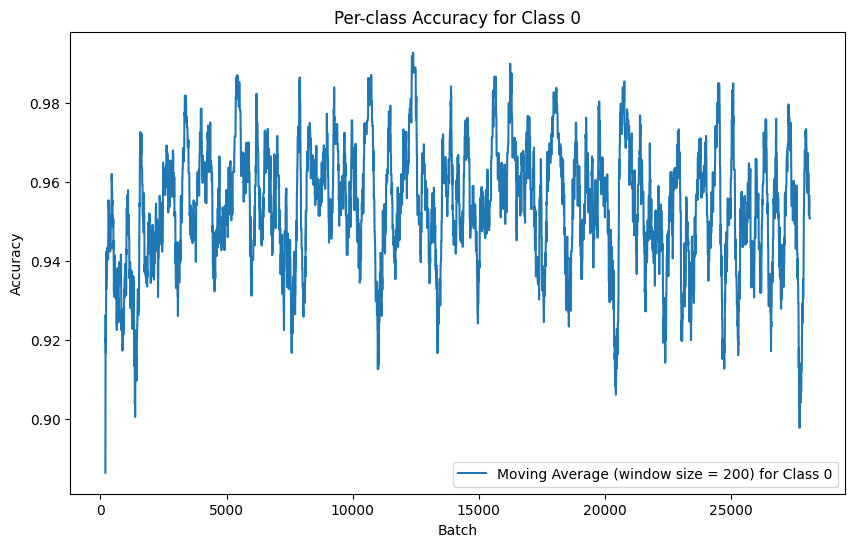

In [121]:
import pandas as pd

# Extract the per-class accuracy for class "0"
class_0_accuracy = []
for epoch_stats in stats.values():
    class_0_accuracy.extend(epoch_stats["by_class"][0]["accuracy"])

# Convert to a pandas Series
class_0_accuracy_series = pd.Series(class_0_accuracy)

# Calculate the moving average with a given window size
window_size = 200
moving_average = class_0_accuracy_series.rolling(window=window_size).mean()

# Plot the original accuracy and the moving average
plt.figure(figsize=[10, 6])
# plt.plot(class_0_accuracy, label="Original Accuracy for Class 0")
plt.plot(moving_average, label=f"Moving Average (window size = {window_size}) for Class 0")
plt.xlabel("Batch")
plt.ylabel("Accuracy")
plt.title("Per-class Accuracy for Class 0")
plt.legend()
plt.show()


In [115]:
len(train_loader) * 4

7500

In [71]:
by_class

defaultdict(<function __main__.<lambda>()>,
            {0: defaultdict(list,
                         {'loss': [2.2861781120300293], 'accuracy': [1.0]}),
             1: defaultdict(list,
                         {'loss': [2.2977771759033203], 'accuracy': [0.0]}),
             2: defaultdict(list,
                         {'loss': [2.30707049369812], 'accuracy': [0.0]}),
             3: defaultdict(list,
                         {'loss': [2.3010430335998535], 'accuracy': [0.0]}),
             4: defaultdict(list,
                         {'loss': [2.302687168121338], 'accuracy': [0.0]}),
             5: defaultdict(list,
                         {'loss': [2.3027639389038086], 'accuracy': [0.0]}),
             6: defaultdict(list,
                         {'loss': [2.3083980083465576], 'accuracy': [0.0]}),
             7: defaultdict(list,
                         {'loss': [2.3103110790252686], 'accuracy': [0.0]}),
             8: defaultdict(list,
                         {'loss': [2.

In [58]:
stats[1]["batch_train_accuracy"]

[0.0625,
 0.15625,
 0.21875,
 0.03125,
 0.15625,
 0.09375,
 0.28125,
 0.1875,
 0.375,
 0.40625,
 0.3125,
 0.46875,
 0.3125,
 0.375,
 0.28125,
 0.34375,
 0.34375,
 0.25,
 0.3125,
 0.3125,
 0.4375,
 0.3125,
 0.3125,
 0.15625,
 0.46875,
 0.46875,
 0.3125,
 0.5625,
 0.59375,
 0.6875,
 0.625,
 0.71875,
 0.5625,
 0.71875,
 0.65625,
 0.71875,
 0.6875,
 0.71875,
 0.65625,
 0.75,
 0.65625,
 0.59375,
 0.625,
 0.75,
 0.75,
 0.59375,
 0.6875,
 0.59375,
 0.625,
 0.53125,
 0.6875,
 0.71875,
 0.6875,
 0.71875,
 0.75,
 0.96875,
 0.84375,
 0.6875,
 0.75,
 0.84375,
 0.6875,
 0.84375,
 0.71875,
 0.8125,
 0.6875,
 0.71875,
 0.8125,
 0.71875,
 0.84375,
 0.71875,
 0.78125,
 0.6875,
 0.75,
 0.875,
 0.78125,
 0.71875,
 0.8125,
 0.78125,
 0.71875,
 0.71875,
 0.71875,
 0.65625,
 0.9375,
 0.78125,
 0.625,
 0.6875,
 0.59375,
 0.65625,
 0.71875,
 0.8125,
 0.625,
 0.78125,
 0.875,
 0.84375,
 0.75,
 0.71875,
 0.78125,
 0.6875,
 0.8125,
 0.8125,
 0.75,
 0.90625,
 0.90625,
 0.78125,
 0.78125,
 0.78125,
 0.78125,
 0.84

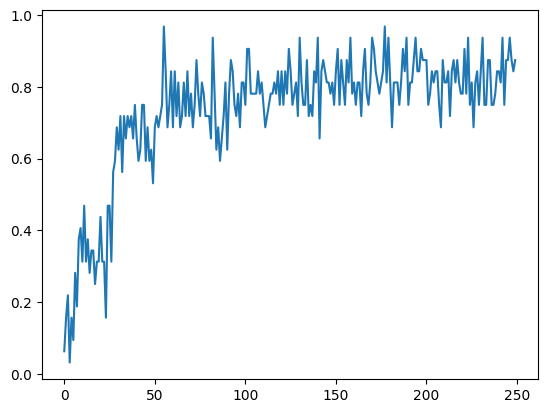

In [50]:
target

tensor([4, 0, 5, 8, 3, 1, 4, 7, 1, 6, 1, 6, 4, 3, 5, 7, 2, 1, 8, 7, 8, 6, 1, 1,
        8, 0, 6, 6, 9, 2, 2, 4])

In [45]:
train_accuracy

0.9214

In [44]:
len(train_loader)

1875

In [ ]:
# Tracking accuracy and loss per class, for train and test
x = {
    # stats for epoch 1
    1: {
        "train_loss": 1.5,
        "test_loss": 2,
        "train_accuracy": 0.97,
        "test_accuracy": 0.95,
        "batch_train_loss": [4, 3.8, ...],
        "batch_train_accuracy": [0.10, 0.16, ...]
        # Also track all of the above but at a per-class level
        "by_class": {
            0: {...},
            1: {...},
        }
    },
    2: {...},
    3: {...}
}

In [28]:
print(output.argmax(1))
print(target)

tensor([7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7])
tensor([4, 9, 0, 1, 5, 7, 6, 2, 4, 0, 4, 1, 3, 3, 6, 1, 4, 0, 1, 8, 4, 1, 5, 7,
        9, 6, 3, 1, 8, 6, 7, 1])


In [29]:
len(train_loader)

1875

In [30]:
1875 * 32

60000